# Hand Direction Analysis (Left vs Right)

이 노트북에서는 손 엑스레이 데이터의 방향(왼손/오른손)을 판별하고, 방향을 하나로 통일하는 전처리 로직을 검토합니다.

## 1. 전제 조건
- 엑스레이 촬영 방식(PA View)에 따라:
    - **오른손**: 엄지손가락(finger-1)이 이미지의 **왼쪽**에 위치합니다.
    - **왼손**: 엄지손가락(finger-1)이 이미지의 **오른쪽**에 위치합니다.
- 판별 로직: `finger-1`(엄지 끝)의 x-좌표 평균과 `finger-16`(새끼손가락 끝)의 x-좌표 평균을 비교합니다.

In [40]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# 경로 설정
IMAGE_ROOT = "/data/ephemeral/home/data/train/DCM"
LABEL_ROOT = "/data/ephemeral/home/data/train/outputs_json"

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna'
]
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

def get_hand_direction_by_coord(label_path):
    with open(label_path, 'r') as f:
        data = json.load(f)
    annotations = data['annotations']
    points_dict = {ann['label']: np.array(ann['points']) for ann in annotations}
    if 'finger-1' not in points_dict or 'finger-16' not in points_dict: return "Unknown"
    f1_x = points_dict['finger-1'][:, 0].mean()
    f16_x = points_dict['finger-16'][:, 0].mean()
    return "Right" if f1_x < f16_x else "Left"

# def get_hand_direction_by_pixel(image_path):
#     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     if img is None: return "Unknown"
#     h, w = img.shape
#     left_sum = img[:, :w//2].sum()
#     right_sum = img[:, w//2:].sum()
#     return "Left" if right_sum > left_sum else "Right"

def get_hand_direction_by_pixel(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return "Unknown"
    
    # 1. 노이즈 제거를 위한 가우시안 블러
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    
    # 2. 이진화 (배경은 날리고 손 영역만 추출, 임계값 30은 상황에 맞게 조절 가능)
    _, thr = cv2.threshold(blur, 30, 255, cv2.THRESH_BINARY)
    
    h, w = thr.shape
    # 3. 무게 중심 계산 (m10/m00)
    M = cv2.moments(thr)
    if M['m00'] == 0: return "Unknown"
    cx = M['m10'] / M['m00']
    
    # 무게 중심이 이미지 중앙(w/2)보다 어느 쪽에 치우쳤는지 확인
    # PA View 기준: 오른손은 엄지가 왼쪽 -> 전체 무게 중심이 약간 왼쪽(Right)일 확률이 높음
    # (주의: 데이터셋 특성에 따라 이 방향은 반대일 수 있으므로 Mismatch 시각화를 꼭 확인해야 함)
    return "Left" if cx > w/2 else "Right"

## 2. 좌표 기반 vs 이미지 기반 판별 정확도 검증
테스트셋은 라벨이 없으므로, 이미지 기반 Heuristic 로직이 얼마나 정확한지 검증합니다.

In [41]:
json_files = []
for root, dirs, files in os.walk(LABEL_ROOT):
    for f in files:
        if f.endswith('.json'): json_files.append(os.path.join(root, f))

mismatch_cases = []
correct_count = 0
for jf in tqdm(json_files):
    correct_dir = get_hand_direction_by_coord(jf)
    if correct_dir == "Unknown": continue
    with open(jf, 'r') as f: data = json.load(f)
    img_path = os.path.join(IMAGE_ROOT, os.path.dirname(os.path.relpath(jf, LABEL_ROOT)), data['filename'].replace('.jpg', '.png'))
    if not os.path.exists(img_path):
        p_dir = os.path.dirname(img_path)
        pngs = [f for f in os.listdir(p_dir) if f.endswith('.png')] if os.path.exists(p_dir) else []
        if pngs: img_path = os.path.join(p_dir, pngs[0])
        else: continue
    pred_dir = get_hand_direction_by_pixel(img_path)
    if correct_dir == pred_dir: correct_count += 1
    else: mismatch_cases.append({"path": img_path, "correct": correct_dir, "pred": pred_dir})

print(f"Correct: {correct_count}/{len(json_files)} ({correct_count/len(json_files)*100:.2f}%)")

100%|██████████| 800/800 [00:44<00:00, 18.04it/s]

Correct: 400/800 (50.00%)


## 3. Mismatch 케이스 시각화

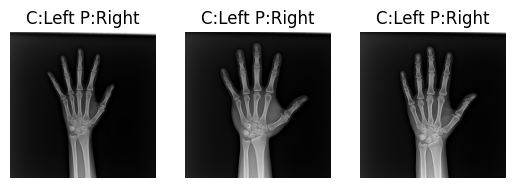

In [42]:
if mismatch_cases:
    for i, case in enumerate(mismatch_cases[:3]):
        img = cv2.cvtColor(cv2.imread(case['path']), cv2.COLOR_BGR2RGB)
        plt.subplot(1, 3, i+1); plt.imshow(img)
        plt.title(f"C:{case['correct']} P:{case['pred']}"); plt.axis('off')
    plt.show()
else: print("All Correct!")

## 4. 시각화 확인 (이미지 + 어노테이션 플립 검증)

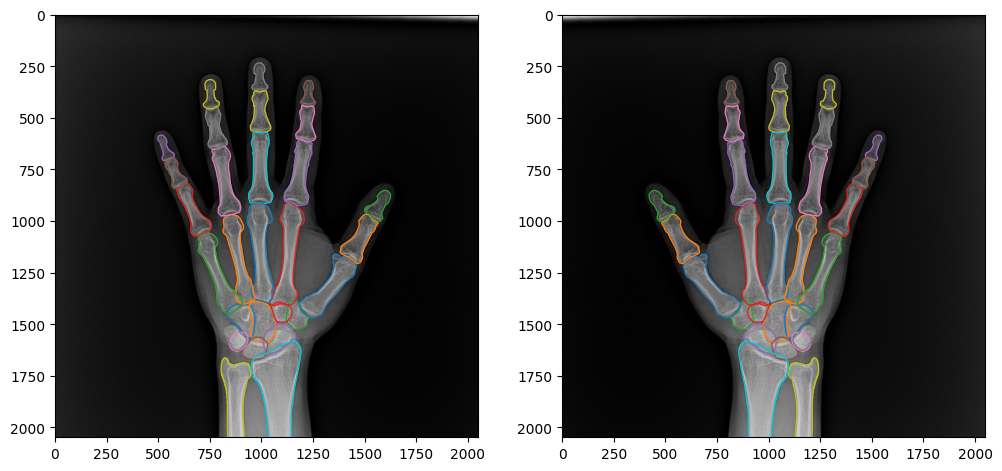

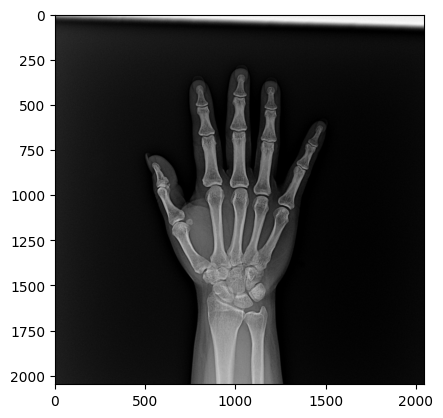

In [38]:
import random
def visualize_direction(json_path):
    with open(json_path, 'r') as f: data = json.load(f)
    img_path = os.path.join(IMAGE_ROOT, os.path.dirname(os.path.relpath(json_path, LABEL_ROOT)), data['filename'].replace('.jpg', '.png'))
    if not os.path.exists(img_path):
        p_dir = os.path.dirname(img_path)
        pngs = [f for f in os.listdir(p_dir) if f.endswith('.png')] if os.path.exists(p_dir) else []
        if pngs: img_path = os.path.join(p_dir, pngs[0])
        else: return
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    direction = get_hand_direction_by_coord(json_path)
    if direction == "Left":
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(img)
        for ann in data['annotations']:
            pts = np.array(ann['points'])
            ax[0].plot(pts[:, 0], pts[:, 1], linewidth=1)
        flipped = cv2.flip(img, 1)
        ax[1].imshow(flipped)
        for ann in data['annotations']:
            pts = np.array(ann['points']).copy()
            pts[:, 0] = w - 1 - pts[:, 0]
            ax[1].plot(pts[:, 0], pts[:, 1], linewidth=1)
        plt.show()
    else: plt.imshow(img); plt.show()

for s in random.sample(json_files, 2): visualize_direction(s)

## 5. 동일 피험자의 왼손(Flip) vs 오른손 일치도 분석

Mean IoU: 0.0506


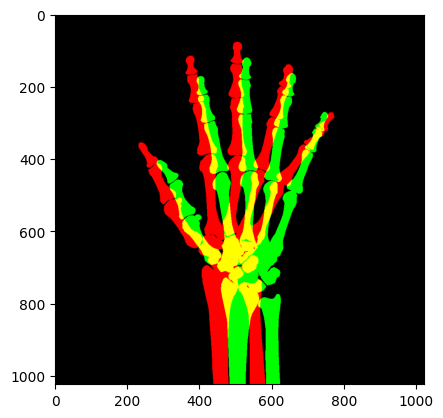

In [39]:
path_r = os.path.join(LABEL_ROOT, "ID001/image1661130828152_R.json")
path_l = os.path.join(LABEL_ROOT, "ID001/image1661130891365_L.json")
def get_resized_mask(path, h=1024, w=1024):
    with open(path, 'r') as f: data = json.load(f)
    mask = np.zeros((h, w, len(CLASSES)), dtype=np.uint8)
    for ann in data['annotations']:
        if ann['label'] in CLASS2IND:
            pts = (np.array(ann['points']) * [w/2048, h/2048]).astype(np.int32)
            ch = np.zeros((h, w), dtype=np.uint8)
            cv2.fillPoly(ch, [pts], 1)
            mask[:, :, CLASS2IND[ann['label']]] = ch
    return mask
mr = get_resized_mask(path_r)
ml = cv2.flip(get_resized_mask(path_l), 1)
if len(ml.shape)==2: ml=ml[:,:,None]
iou = (mr & ml).sum() / ((mr | ml).sum() + 1e-6)
print(f"Mean IoU: {iou:.4f}")
ov = np.zeros((1024, 1024, 3), dtype=np.uint8)
ov[mr.sum(-1)>0, 0] = 255
ov[ml.sum(-1)>0, 1] = 255
plt.imshow(ov); plt.show()